In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_validate, train_test_split, cross_val_score)
from sklearn.metrics import make_scorer,recall_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from time import time
plt.rc('font', family='NanumGothic')

In [31]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

## 0. Data

In [32]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
df_train.head()

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


In [33]:
df_train = df_train.drop('ID', axis=1)
df_test = df_test.drop('ID', axis=1)

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Columns: 183 entries, 착과량(int) to 2022-11-28 엽록소
dtypes: float64(182), int64(1)
memory usage: 3.1 MB


In [35]:
df_train.describe()

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
count,2207.000000,2207.00000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,...,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,406.222474,243.72995,315.186226,358.824196,337.005211,3.774807,3.736928,3.701495,3.663435,3.627503,...,68.992036,68.890661,68.791536,68.692934,68.593709,68.493569,68.393050,68.291350,68.192009,68.093096
std,218.978302,35.88914,66.327994,68.862898,64.859684,0.774181,0.764067,0.754751,0.745394,0.733896,...,4.124586,4.124429,4.125817,4.128586,4.130005,4.130072,4.131859,4.134976,4.135591,4.136995
min,1.000000,95.00000,95.000000,123.000000,109.000000,2.300000,2.200000,2.200000,2.200000,2.200000,...,54.246243,54.154888,54.143798,54.028089,53.884892,53.695860,53.649032,53.644994,53.450069,53.379849
25%,221.000000,223.00000,271.500000,313.500000,294.000000,3.100000,3.100000,3.050000,3.000000,3.000000,...,66.195524,66.075372,65.995234,65.906703,65.765257,65.691065,65.609606,65.487863,65.374528,65.278624
50%,404.000000,243.00000,316.000000,364.000000,340.500000,3.800000,3.700000,3.700000,3.700000,3.600000,...,69.048956,68.920295,68.841060,68.731164,68.647716,68.514740,68.392436,68.292889,68.207648,68.102235
75%,593.500000,267.00000,361.000000,402.000000,380.000000,4.400000,4.400000,4.300000,4.300000,4.300000,...,71.740281,71.615746,71.504264,71.390195,71.311027,71.227033,71.152030,71.038257,70.947707,70.850934
max,799.000000,381.00000,559.000000,584.000000,571.500000,5.300000,5.300000,5.200000,5.200000,5.100000,...,83.363883,83.227379,83.036103,82.978876,82.842139,82.722266,82.575149,82.491041,82.371832,82.321938


In [36]:
X_train = df_train.loc[:, '수고(m)':]
y_train = df_train['착과량(int)']

## 1. EDA

feature 분포

<AxesSubplot:xlabel='수관폭평균', ylabel='Count'>

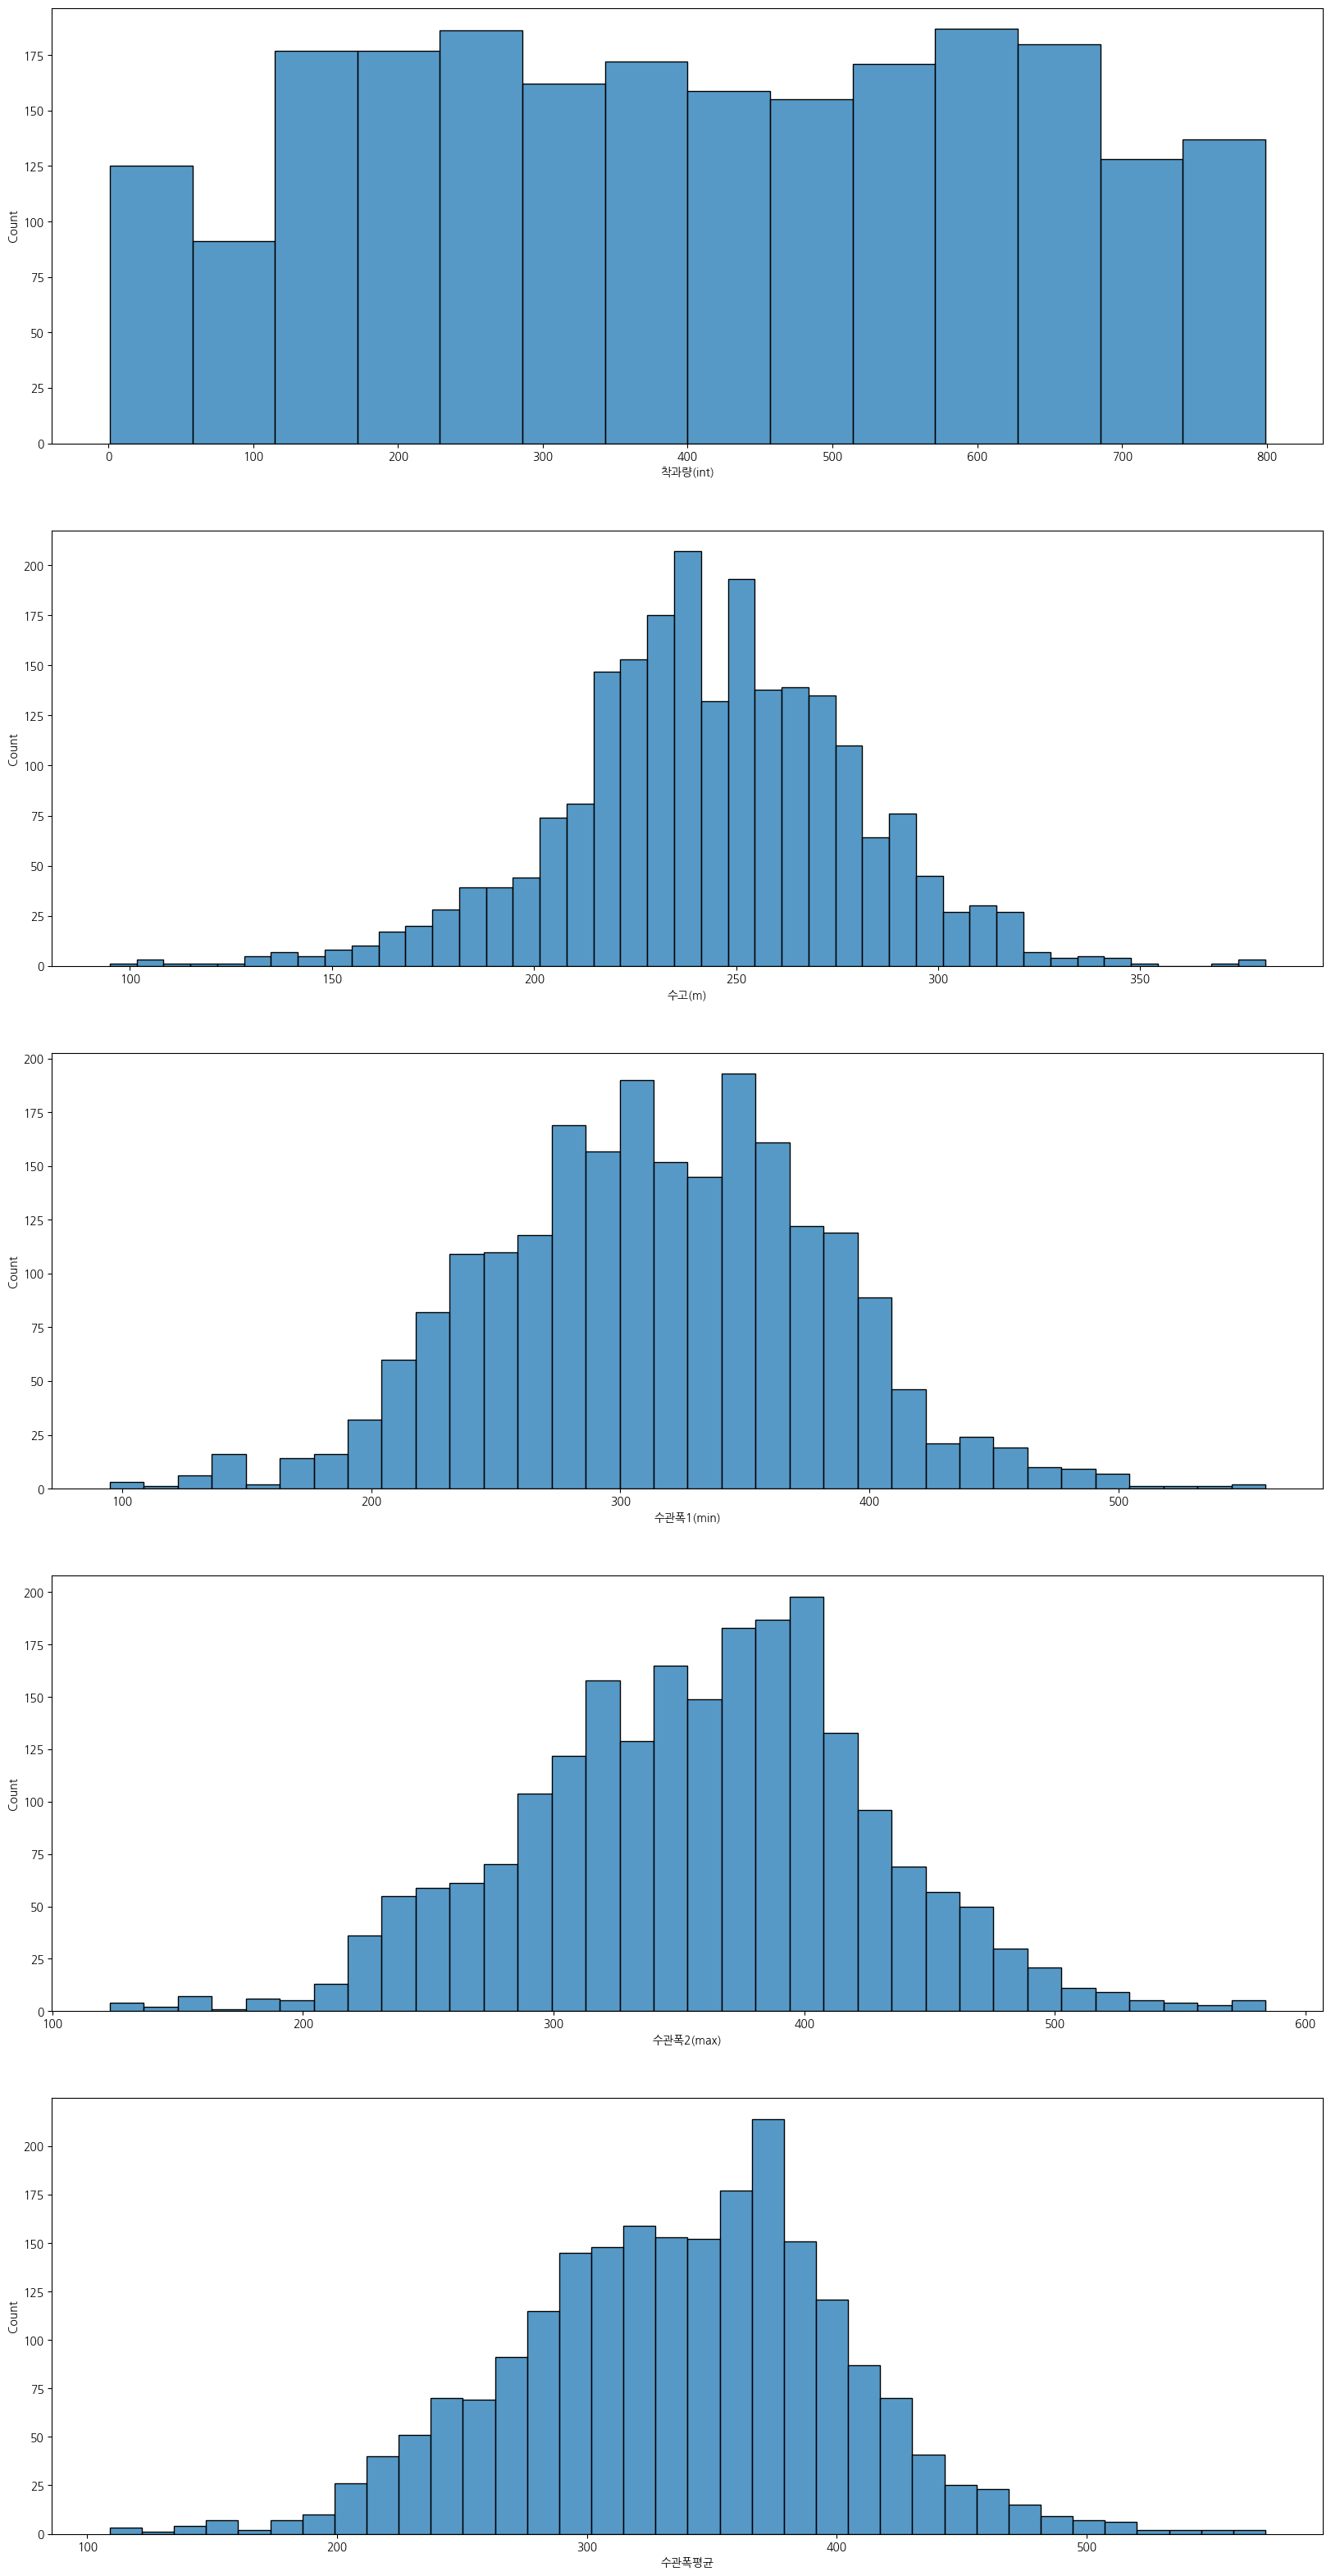

In [37]:
plt.figure(figsize=(20,40))

plt.subplot(5,1,1)
sns.histplot(df_train['착과량(int)'])

plt.subplot(5,1,2)
sns.histplot(df_train['수고(m)'])

plt.subplot(5,1,3)
sns.histplot(df_train['수관폭1(min)'])

plt.subplot(5,1,4)
sns.histplot(df_train['수관폭2(max)'])

plt.subplot(5,1,5)
sns.histplot(df_train['수관폭평균'])

C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='착과량(int)'>

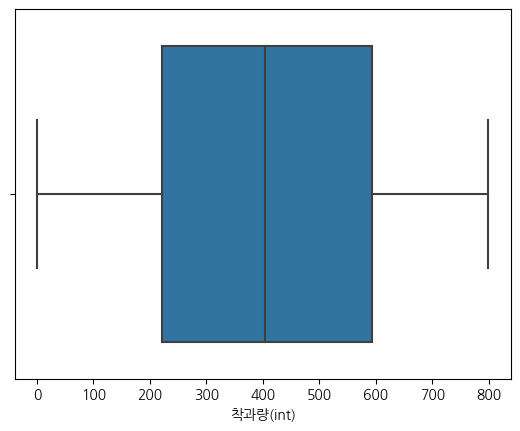

In [38]:
sns.boxplot(df_train['착과량(int)'])

feaeture와 target의 상관관계  
뚜렷한 상관관계는 보이지 않음

<AxesSubplot:xlabel='2022-09-01 새순', ylabel='착과량(int)'>

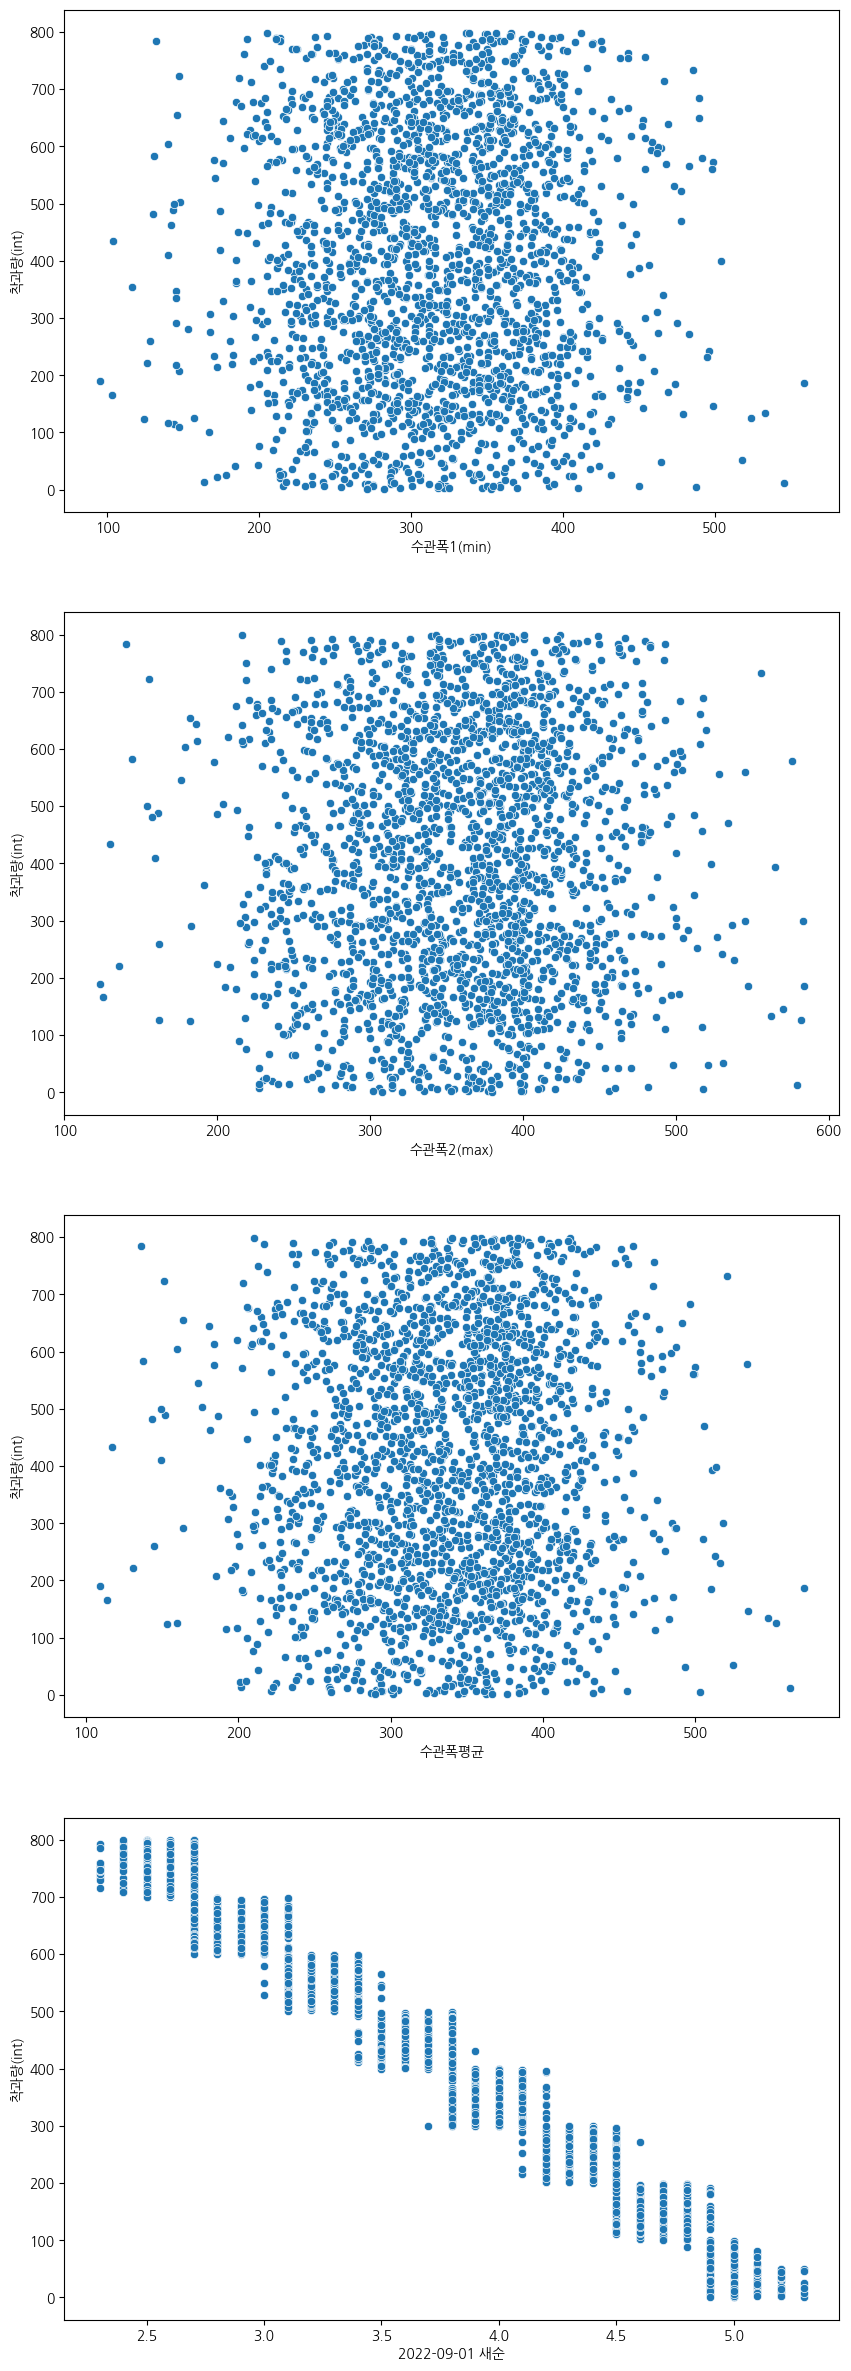

In [39]:
plt.figure(figsize=(10,30))

plt.subplot(4,1,1)
sns.scatterplot(x=df_train[df_train.columns[2]], y=df_train['착과량(int)'])

plt.subplot(4,1,2)
sns.scatterplot(x=df_train[df_train.columns[3]], y=df_train['착과량(int)'])

plt.subplot(4,1,3)
sns.scatterplot(x=df_train[df_train.columns[4]], y=df_train['착과량(int)'])

plt.subplot(4,1,4)
sns.scatterplot(x=df_train[df_train.columns[5]], y=df_train['착과량(int)'])

In [40]:
plt.figure(figsize=(12,10))
cor = df_train.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

<Figure size 1200x1000 with 0 Axes>

## 2-1. Feature Selection1
시계열로 처리하는 것 말고 feature 각각으로 보자면?

In [106]:
def run_sfs(X, y, model, n_features=1):
    model_name = str(model).split('(')[0]
    df = pd.DataFrame()
    
    tic_fwd = time()
    sfs_fwd = SequentialFeatureSelector(model, 
                                        n_features_to_select=n_features, 
#                                         tol=5,
                                        direction='forward', 
#                                         cv=5, 
#                                         scoring=nmae,  # 'roc_auc'
                                        n_jobs=-1)
    sfs_fwd.fit(X, y)
    toc_fwd = time()

    print(f'Forward SFS : {sfs_fwd.get_feature_names_out()}')
    print(len(sfs_fwd.get_feature_names_out()), 'features selected')
    print(f'{toc_fwd - tic_fwd:.3f}s')
    df = df.append(pd.Series([sfs_fwd.get_feature_names_out(), len(sfs_fwd.get_feature_names_out()), 'sfs_fwd', model_name]), 
                   ignore_index=True)
    
    
    tic_bwd = time()
    sfs_bwd = SequentialFeatureSelector(model, 
                                        n_features_to_select=n_features, 
#                                         tol=3,
                                        direction='backward', 
#                                         cv=5, 
#                                         scoring=nmae,  #'roc_auc' 
                                        n_jobs=-1)
    sfs_bwd.fit(X, y)
    toc_bwd = time()
    
    print(f'Backward SFS : {sfs_bwd.get_feature_names_out()}')
    print(len(sfs_bwd.get_feature_names_out()))
    print(f'{toc_bwd - tic_bwd:.3f}s')
    df = df.append(pd.Series([sfs_bwd.get_feature_names_out(), len(sfs_bwd.get_feature_names_out()), 'sfs_bwd', model_name]), 
                   ignore_index=True)
    
    return df

In [113]:
df = run_sfs(X_train, y_train, models[0], n_features=1)
df

C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has

C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has

C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has

C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lynn1\anaconda3\envs\data-analysis\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

## 2-2. Feature Selection2 + Model Fitting

In [41]:
cor_target = abs(cor["착과량(int)"])
# cor_target
relevant_features = cor_target[cor_target>0.9][1:]
relevant_features[:10]

2022-09-01 새순    0.980777
2022-09-02 새순    0.980766
2022-09-03 새순    0.980633
2022-09-04 새순    0.980772
2022-09-05 새순    0.980526
2022-09-06 새순    0.980885
2022-09-07 새순    0.980784
2022-09-08 새순    0.980261
2022-09-09 새순    0.980388
2022-09-10 새순    0.980705
Name: 착과량(int), dtype: float64

In [42]:
X_train = df_train[relevant_features.index]
X_test = df_test[relevant_features.index]
X_train.head()

,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,2022-09-09 새순,2022-09-10 새순,...,2022-10-28 새순,2022-10-29 새순,2022-10-30 새순,2022-10-31 새순,2022-11-01 새순,2022-11-02 새순,2022-11-03 새순,2022-11-04 새순,2022-11-05 새순,2022-11-06 새순
0,2.8,2.8,2.7,2.7,2.7,2.7,2.6,2.6,2.6,2.6,...,1.4,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.2,1.1
1,3.3,3.3,3.3,3.2,3.2,3.1,3.1,3.1,3.0,3.0,...,1.5,1.4,1.4,1.4,1.3,1.3,1.3,1.2,1.2,1.2
2,3.0,2.9,2.9,2.9,2.9,2.8,2.8,2.8,2.8,2.7,...,1.4,1.4,1.3,1.3,1.3,1.3,1.3,1.2,1.2,1.2
3,3.1,3.0,3.0,3.0,3.0,2.9,2.9,2.9,2.8,2.8,...,1.5,1.5,1.4,1.4,1.4,1.4,1.3,1.3,1.3,1.3
4,3.7,3.6,3.6,3.6,3.5,3.5,3.5,3.4,3.4,3.3,...,1.7,1.6,1.6,1.6,1.5,1.5,1.5,1.4,1.4,1.4


In [28]:
def remove_outlier(X_col):
    df = pd.DataFrame(X_col)
    
    q1 = df.quantile(0.1)
    q3 = df.quantile(0.9)
    iqr = q3 - q1
    
    df_2 = df[(df <= q3 + (3*iqr)) and (df >= q1 - (3*iqr))]
    df_2 = df_2.reset_index(drop=True)
    
    return df_2

In [45]:
param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
            "penalty" : ["l2"], 
#             'class_weight':[{0:0.1, 1:0.9}],
            'random_state':[42, 99]}

param_rf = {'n_estimators': [100, 500],
            'max_depth': [None, 3, 5, 7, 9, 11],
            'min_samples_split' : [2, 5],
#             'class_weight':[{0:0.1, 1:0.9}], 
            'random_state':[99]}

param_lgbm = {'n_estimators': [50, 100, 500],
              'max_depth':[-1, 5, 7, 9, 11],
#               'num_leaves':[40, 60, 80],
#               'min_child_samples':[5,10,15],
#               'class_weight':[{0:0.1, 1:0.9}],
#               'reg_alpha':[0, 0.01], 
              'random_state':[42, 99]}

param_xgb = {'n_estimators': [50, 100, 500],
             'max_depth':[-1, 3, 5, 7, 9, 11],
#              'num_leaves':[30, 60],
#              'gamma': [0.5, 1, 2],
#              'class_weight':[{0:0.1, 1:0.9}],
             'random_state':[42, 99]}

model_params = [
                param_lr, 
                param_rf, 
                param_lgbm, 
                param_xgb
               ]

models = [
          LogisticRegression(random_state=42),
          RandomForestRegressor(n_estimators=500, max_depth=5, random_state=99),
          LGBMRegressor(n_estimators=500, max_depth=5, random_state=42),
          XGBRegressor(n_estimators=500, max_depth=5, random_state=42)
         ]

In [49]:
model = models[1]
model_param = model_params[1]

grid_model = GridSearchCV(estimator=model, 
                          param_grid=model_param, 
                          cv=5, 
                          n_jobs=-1, 
                          verbose=2)
grid_model.fit(X_train, y_train)
print(grid_model.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9701657709578042


In [51]:
print(grid_model.best_params_)

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 99}


In [53]:
pred = grid_model.predict(X_test)

In [55]:
submission['착과량(int)'] = pred
submission.to_csv('submission_1.csv', index=False, encoding='utf-8-sig')

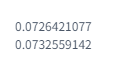

## 2-3. Feature Selection3 & Model Fitting

In [61]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

df_train = df_train.drop(['ID'], axis=1)
df_test = df_test.drop('ID', axis=1)

df_train.head()

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,3.5,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


In [90]:
df_train

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,3.5,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,119,230.0,353.0,367.0,360.0,4.7,4.6,4.5,4.5,4.4,...,66.347384,66.293609,66.193131,66.176590,66.109845,66.008775,65.889675,65.734066,65.586656,65.560547
2203,611,266.0,337.0,400.0,368.5,3.1,3.0,3.0,3.0,2.9,...,73.438844,73.432194,73.355195,73.329491,73.271361,73.088750,73.071705,73.069036,72.952559,72.944396
2204,650,237.0,353.0,362.0,357.5,3.0,3.0,2.9,2.9,2.9,...,67.576066,67.404347,67.394009,67.247428,67.117025,66.933771,66.734617,66.572095,66.506006,66.479459
2205,363,281.0,337.0,403.0,370.0,3.9,3.9,3.8,3.8,3.8,...,66.766379,66.602606,66.510781,66.334637,66.323613,66.248731,66.202532,66.108962,65.934979,65.812084


In [83]:
X_train = df_train.iloc[:, 5:]
X_test = df_test.iloc[:, 4:]
y_train = df_train['착과량(int)']
X_col = X_train.columns
X_col_week = [X_col[(i-1)*7 : i*7].tolist() for i in range(1,13)]
X_col_2 = X_train.columns[89:]
X_col_week_2 = [X_col_2[(i-1)*7 : i*7].tolist() for i in range(1,13)]
X_col_week += X_col_week_2
X_col_week

[['2022-09-01 새순',
  '2022-09-02 새순',
  '2022-09-03 새순',
  '2022-09-04 새순',
  '2022-09-05 새순',
  '2022-09-06 새순',
  '2022-09-07 새순'],
 ['2022-09-08 새순',
  '2022-09-09 새순',
  '2022-09-10 새순',
  '2022-09-11 새순',
  '2022-09-12 새순',
  '2022-09-13 새순',
  '2022-09-14 새순'],
 ['2022-09-15 새순',
  '2022-09-16 새순',
  '2022-09-17 새순',
  '2022-09-18 새순',
  '2022-09-19 새순',
  '2022-09-20 새순',
  '2022-09-21 새순'],
 ['2022-09-22 새순',
  '2022-09-23 새순',
  '2022-09-24 새순',
  '2022-09-25 새순',
  '2022-09-26 새순',
  '2022-09-27 새순',
  '2022-09-28 새순'],
 ['2022-09-29 새순',
  '2022-09-30 새순',
  '2022-10-01 새순',
  '2022-10-02 새순',
  '2022-10-03 새순',
  '2022-10-04 새순',
  '2022-10-05 새순'],
 ['2022-10-06 새순',
  '2022-10-07 새순',
  '2022-10-08 새순',
  '2022-10-09 새순',
  '2022-10-10 새순',
  '2022-10-11 새순',
  '2022-10-12 새순'],
 ['2022-10-13 새순',
  '2022-10-14 새순',
  '2022-10-15 새순',
  '2022-10-16 새순',
  '2022-10-17 새순',
  '2022-10-18 새순',
  '2022-10-19 새순'],
 ['2022-10-20 새순',
  '2022-10-21 새순',
  '2022-10-22 새순',
  '20

In [85]:
X_train_2 = pd.DataFrame()

for idx, col_set in enumerate(X_col_week):
    col_name = str(idx+1)
    X_train_2[col_name] = X_train[col_set].mean(axis='columns')
    
X_train_2

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,2.714286,2.542857,2.357143,2.185714,2.014286,1.842857,1.657143,1.485714,1.300000,1.142857,...,76.672612,75.971182,75.256592,74.773701,74.041398,73.315917,72.775893,72.147554,71.445402,70.789887
1,3.214286,2.971429,2.771429,2.571429,2.328571,2.100000,1.871429,1.628571,1.400000,1.157143,...,78.012503,77.081535,76.333263,75.289362,74.384805,73.683723,73.309636,72.751656,71.935010,71.337765
2,2.885714,2.700000,2.514286,2.314286,2.128571,1.928571,1.728571,1.528571,1.342857,1.171429,...,77.315391,76.391354,75.733305,75.280825,74.637770,74.040626,73.453902,72.831548,71.938959,71.195315
3,2.985714,2.771429,2.571429,2.371429,2.185714,2.014286,1.842857,1.642857,1.442857,1.271429,...,76.298724,75.630212,74.943987,74.366115,73.460525,72.625715,71.937963,71.223404,70.510517,69.912301
4,3.571429,3.300000,3.057143,2.800000,2.571429,2.328571,2.100000,1.871429,1.600000,1.371429,...,74.709047,73.997685,73.160137,72.537514,71.837562,71.175767,70.224340,69.395179,68.697302,68.253439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,4.485714,4.128571,3.800000,3.457143,3.128571,2.800000,2.471429,2.142857,1.828571,1.471429,...,72.490735,71.719848,71.067960,70.322468,69.659297,69.005002,68.414696,67.769865,67.137458,66.323849
2203,2.971429,2.785714,2.571429,2.385714,2.200000,2.014286,1.828571,1.628571,1.414286,1.228571,...,80.071013,79.287309,78.412043,77.766784,77.122757,76.541075,75.823792,75.052581,74.204607,73.427614
2204,2.914286,2.728571,2.528571,2.328571,2.142857,1.928571,1.742857,1.542857,1.357143,1.142857,...,73.787201,73.064256,72.322871,71.891928,71.342793,70.534221,69.750299,69.012781,68.158129,67.477568
2205,3.800000,3.514286,3.257143,2.971429,2.700000,2.428571,2.157143,1.857143,1.585714,1.300000,...,72.599101,72.058009,71.206827,70.494766,69.865928,69.325710,68.668028,68.052669,67.435918,66.641034


In [87]:
X_test_2 = pd.DataFrame()

for idx, col_set in enumerate(X_col_week):
    col_name = str(idx+1)
    X_test_2[col_name] = X_test[col_set].mean(axis='columns')
    
X_test_2

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,4.142857,3.828571,3.500000,3.185714,2.885714,2.585714,2.300000,2.000000,1.700000,1.400000,...,78.623092,77.986499,77.476424,76.846826,75.948507,75.072655,74.170076,73.516733,72.895613,72.032739
1,2.471429,2.342857,2.171429,2.000000,1.842857,1.685714,1.542857,1.385714,1.257143,1.114286,...,73.636065,73.067233,72.493256,71.978806,71.624545,71.101325,70.217604,69.530308,68.898429,68.349176
2,4.571429,4.228571,3.871429,3.542857,3.228571,2.900000,2.571429,2.171429,1.828571,1.514286,...,80.646428,79.874685,79.027789,78.208839,77.476072,76.917899,76.434607,75.776702,75.026879,74.261671
3,3.542857,3.300000,3.071429,2.828571,2.585714,2.314286,2.071429,1.828571,1.600000,1.314286,...,79.646934,78.748746,78.021841,77.315650,76.622116,76.014191,75.446094,74.825582,74.086841,73.450246
4,2.657143,2.485714,2.342857,2.185714,2.000000,1.842857,1.657143,1.500000,1.328571,1.157143,...,78.660329,77.900314,77.125136,76.350718,75.750470,74.919081,74.056725,73.436529,72.809647,72.126468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2.414286,2.257143,2.085714,1.942857,1.785714,1.657143,1.500000,1.342857,1.200000,1.057143,...,76.755442,76.093294,75.243379,74.856999,74.469614,73.627442,72.844854,72.163444,71.337378,70.489438
2204,4.014286,3.700000,3.400000,3.142857,2.857143,2.542857,2.242857,1.942857,1.628571,1.342857,...,72.725111,72.209967,71.650686,70.924754,70.215749,69.374245,68.762033,68.136941,67.341325,66.481119
2205,3.728571,3.471429,3.228571,2.971429,2.714286,2.442857,2.171429,1.900000,1.657143,1.385714,...,69.305727,68.591490,67.982021,67.249300,66.446172,65.951837,65.301228,64.634048,63.973455,63.124483
2206,4.328571,4.028571,3.671429,3.357143,3.071429,2.728571,2.428571,2.085714,1.785714,1.471429,...,71.166258,70.391218,69.503777,68.900552,68.320912,67.437033,66.597436,65.840791,64.921686,64.198191


In [88]:
model = models[1]
model_param = model_params[1]

grid_model = GridSearchCV(estimator=model, 
                          param_grid=model_param, 
                          cv=5, 
                          n_jobs=-1, 
                          verbose=2)
grid_model.fit(X_train_2, y_train)
print(grid_model.best_score_)
print(grid_model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9699558903982679
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 99}


In [89]:
pred = grid_model.predict(X_test_2)
submission['착과량(int)'] = pred
submission.to_csv('submission_2.csv', index=False, encoding='utf-8-sig')

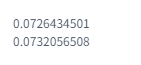